# Wave-fitting for lattice distortion measurements
This example notebook demonstrates the wave-fitting approach for measuring lattice distortions, which can be used to quantify local variations in lattice parameters/strain, local rotation, etc., without need to define a global reference. Here we apply the technique to an atomic resolution HAADF STEM image of a Ca$_2$RuO$_4$ thin film exhibiting phase coexistence.

The method used is described in detail in [Smeaton, M. A., El Baggari, I., Balazs, D. M., Hanrath, T., & Kourkoutis, L. F. (2021). Mapping defect relaxation in quantum dot solids upon in situ heating. ACS nano, 15(1), 719-726.](https://doi.org/10.1021/acsnano.0c06990)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from tifffile import imread
import kemstem
%matplotlib widget
print(f'{kemstem.__version__=}')

kemstem.__version__='0.0.3'


# Data loading and preprocessing
We begin by loading a low magnification atomic resolution HAADF STEM image of our film, and performing some basic preprocessing before beginning analysis. Here, the image is cropped to a square for ease of analysis and the intensity is normalized between 0 and 1 for interpretability.

Image shape (1982, 2018), normalized to min: 0.0, max: 1.0
Cropped to (1982, 1982)


(-0.5, 1981.5, 1981.5, -0.5)

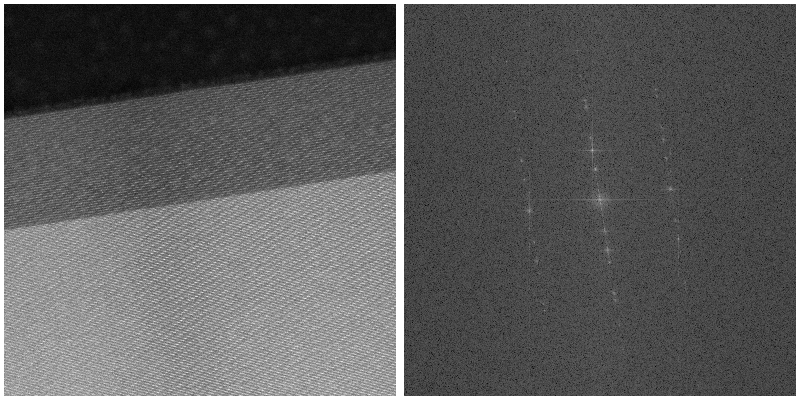

In [2]:
filename = 'data/rI_2127 postcool 936.7 kx_0_HAADF.tif'
image = imread(filename)
image = image - image.min()
image = image/image.max()
print(f'Image shape {image.shape}, normalized to min: {image.min()}, max: {image.max()}')


image = image[:min(image.shape),:min(image.shape)]
print(f'Cropped to {image.shape}')

pattern_log = kemstem.fourier.peakpick.prepare_fourier_pattern(image,log=True)
pattern_c = kemstem.fourier.peakpick.prepare_fourier_pattern(image)

fig,ax = plt.subplots(1,2,constrained_layout=True,figsize=(8,4))
ax[0].matshow(image,cmap='gray')
ax[0].axis('off')
ax[1].matshow(pattern_log,cmap='gray')
ax[1].axis('off')

# Identifying FFT peaks of interest
Here we can select the lowest order in-plane peak in the FFT to analyze the relaxation of the film.

The next cell allows these peaks to be picked manually, or uncomment the following cell to use a preselected set of peak positions.

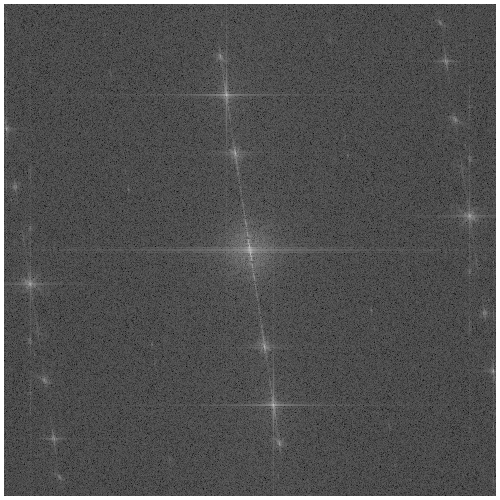

In [3]:
selected_peaks = kemstem.fourier.peakpick.select_peaks(pattern_log,zoom=400,select_conjugates=False,figsize=(5,5),delete_within=5)

In [ ]:
# uncomment and run to use preselected peak(s)
#selected_peaks = np.array([[ 934.44483857],
#       [1350.59370792]])

In [4]:
p0 = np.array(selected_peaks).T
print(f'X positions: {p0[:,1]}')
print(f'Y positions: {p0[:,0]}')

X positions: [1350.59370792  966.59318724]
Y positions: [936.03382377 835.15233105]


# Fitting FFT peaks
Next, we fit the peak using 2D gaussian. Here only the peak position is important, and it is not critical that our fourier mask is perfectly centered on the peak, but it will not hurt to have refined the position nicely.

(591.0, 1391.0, 1391.0, 591.0)

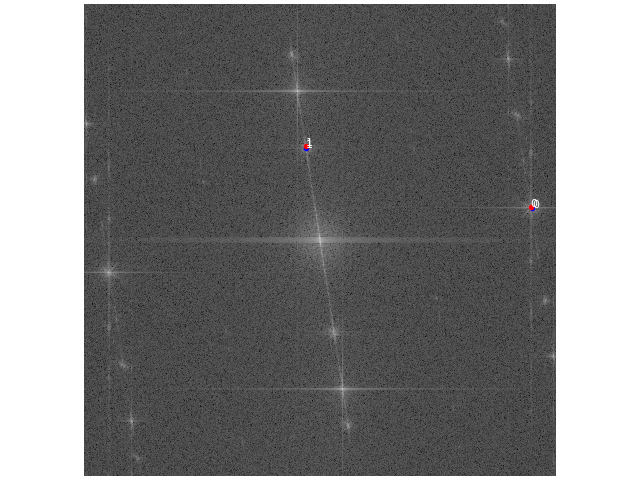

In [5]:
peaks_ref = kemstem.fourier.peakpick.refine_peaks_com(gaussian_filter(pattern_log,1), p0, crop_window=3,iters=20)
fig,ax = plt.subplots(1,1,constrained_layout=True)
kemstem.util.viz.plot_numbered_points(pattern_log,p0,ax=ax,color='b',zoom=400)
kemstem.util.viz.plot_numbered_points(None,peaks_ref,ax=ax,color='r')
ax.axis('off')

# Fourier Filtering
Next we fourier filter the peak. The `sigma` used here will inversely relate to the resolution or coarsening length of the fourier filtered signal in real space, so it should be chosen with care as this will carry on to the wave-fitting analysis.
The real part of the fourier filtered signal which will be fit to measure the local lattice parameter variations is plotted on the left, while the absolute value of the signal is plotted in the middle which gives a nice idea of intensity variations in the peak of interest.

Coarsening markers indicate the coarsening length set by `sigma` in the bottom right of each image.

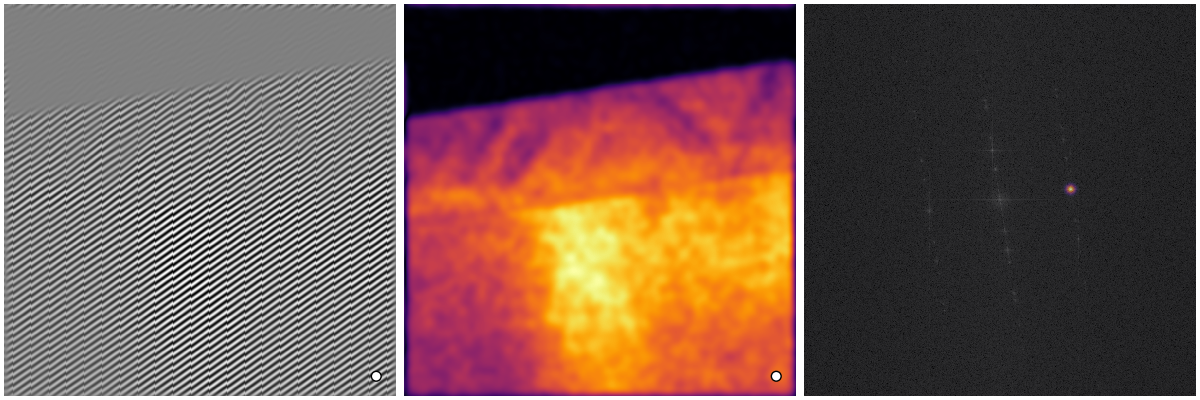

In [6]:
peak_index = 0
sigma= 15
filtered_im, filtered_ft, mask = kemstem.fourier.fourier_filter(pattern_c,peaks_ref[peak_index,:],sigma=sigma)

# Real space amplitude of the selected peak is plotted below
fig,ax = plt.subplots(1,3,constrained_layout=True,figsize=(12,4))
ax[0].matshow(np.real(filtered_im),cmap='gray')
ax[0].axis('off')
ax[1].matshow(np.abs(filtered_im),cmap='inferno') # replacing np.abs with np.real will show sinusoidal
                                               # fringe convenient for identifying dislocations
ax[1].axis('off')
ax[2].matshow(pattern_log,cmap='gray')
ax[2].matshow(mask,alpha=.5,cmap='inferno')
ax[2].axis('off')

kemstem.util.coarsening_marker(ax[0],kemstem.fourier.coarsening_length(filtered_im.shape[0],sigma),facecolor='w',edgecolor='k')
kemstem.util.coarsening_marker(ax[1],kemstem.fourier.coarsening_length(filtered_im.shape[0],sigma),facecolor='w',edgecolor='k')

# Identifying wave-fitting parameters
Wave-fitting quantifies changes in a lattice vector by fitting small patches of the real part of the real part of the Fourier filtered signal (or 'grating') from a peak of interest with sine waves. The frequency of the fit waves is inversely related to the local lattice parameter, allowing variations to be identified in this fit parameter.

Two critical parameters in this process are the `patch_size`, which sets the size of each local patch of the grating to be fit and should include just a couple wavelengths of the wave, and the `patch_step`, which sets the distance between adjacent patches and consequently the sampling of the resulting maps.

The `patch_size` parameter can be chosen with the below test function which shows a fit to a single patch - the patch and fit should match in periodicity and orientation, and the patch should include only a small number (but at least one) sinusoidal period.

38809 total patches, testing on 9702


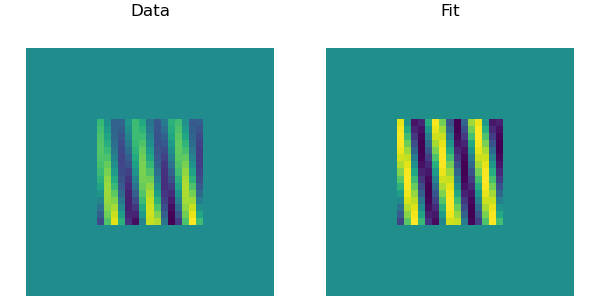

In [7]:
patch_size = 15
patch_step = 10

grating = np.real(filtered_im)
grating = grating / grating.max()
guess = kemstem.fourier.wavefit.peak_to_fit_guess(peaks_ref[peak_index,:],np.array(grating.shape))
popt,perr,data_fits = kemstem.fourier.wavefit.test_fit(grating,patch_size,patch_step,guess,test_patch_idx = None)
_ = kemstem.util.viz.plot_fit_comparison(data_fits,figsize=(6,3))


# Wave-fitting
Next, we can repeat this process on patches sampled from across the entire grating to measure the local lattice parameter variations across the full image. This process is parallelized with multiprocessing - the number of fits allotted to each process can be controlled with chunksize, or left as None to sploit the work across 20 chunks

In [8]:
amplitude,spacing,rotation,sampled_points = kemstem.fourier.wavefit.fit_grating(grating,patch_size,patch_step,guess,chunksize=None)


# of patches: 38809
Using chunk size: 1940


The local amplitude, spacing, and rotation are returned for each patch fit, as well as the positions of the patches (`sampled_points`). The spacing is visualized below, which shows signficant changes between the calcium ruthenate film and lanthanum aluminate substrate, as well as striped variations within the film indicating the coexistence of multiple structural phases

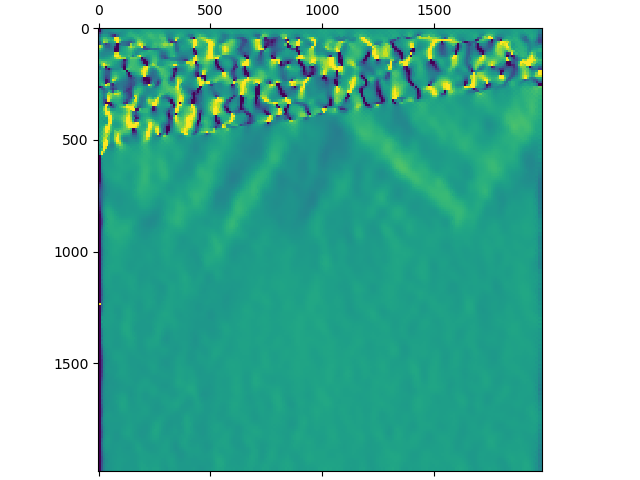

In [9]:
def clip_intensities(data,pct):
    return (np.percentile(data.ravel(),pct), np.percentile(data.ravel(),100-pct))
clipvals = clip_intensities(spacing,1)
fig,ax = plt.subplots(1,1,constrained_layout=True)
ax.matshow(spacing,vmin=clipvals[0],vmax=clipvals[1])